<span style='font-family:"Times New Roman"'> <span style='font-size:20px'> 
# <center>Shake Table Analysis Using Machine Learning Example: Preprocessing</center>
<br>
<br>
<center>Kayla Erler and Gilberto Mosqueda$^1$<center>
<br>
*<center>$^1$Department of Structural Engineering, University of California, San Diego, CA, U.S.A.<center>*
 <br>
<br>
<strong><center>SUMMARY<center></strong>
<br>
<br>   
<div style="text-align: justify">This series of notebooks entails the investigation of applications of machine learning algorithms for shake table data. The Caltrans Seismic Response Modification Device (SRMD) Testing Facility houses a testing machine used primarily for applying displacement control loading protocols to test seismic isolation bearings. One of the primary outcomes from tests is measurement of the dynamic force response. The testing machine has some inherent horizontal forces due to inertia and machine friction that must be corrected to provide the device force response. The current correction procedure requires a test done with the same signal for the real test with a bare or empty table. The goal of this series of notebooks is to characterize these empty table runs in order to eliminate their need through the use of machine learning. The first step in the process is to properly filter signal data to aid in the process of forming accurate predictions. Several well-known filters are used to this end and will be demonstrated in this notebook. This notebook has several components for visualization that are removed in the later compiled function for the next notebook in the series.</div>

## References and Licensing
This report examines data from the seismic response modification device (SRMD) empty table runs. More details on the testing facility can be found at the following link:
> • [Caltrans Seismic Response Modification Device (SRMD) Test Facility](https://se.ucsd.edu/facilities/laboratory-listing/srmd)

The data published in DesignSafe and can be found in the link below:
> • [TBD]

Citation and Licensing:
> •	[Erler et al. (2024)] "Leveraging Machine Learning Algorithms for Regression Analysis in Shake Table Data Processing". WCEE2024
<br>
> •	[Rathje et al. (2017)](https://doi.org/10.1061/(ASCE)NH.1527-6996.0000246) "DesignSafe: New Cyberinfrastructure for Natural Hazards Engineering". ASCE: Natural Hazards Review / Volume 18 Issue 3 - August 2017
<br>
> •	This software is distributed under the [GNU General Public License](https://www.gnu.org/licenses/gpl-3.0.html).

## Table of Contents
* [1. Introduction](#first-bullet)
* [2. Import Python Libraries](#second-bullet)
* [3. Load Data](#third-bullet)
* [4. Filter Design](#fourth-bullet)
* [5. Signal Visualization](#fifth-bullet)

## 1. Introduction  <a class="anchor" id="first-bullet">
<br> 
 <div style="text-align: justify">
This notebook focuses on the preprocessing functions that will be later used in the machine learning application notebooks. The data output from the SRMD testing facility is shown per channel. Filters are needed for the velocity and acceleration data. Although acceleration is recorded by the machine, the noise-to-signal ratio is too low for the low acceleration amplitude runs to obtain useful information. Using an Savitzky-Golay filter, the displacement signal can be accurately derived for both velocity and acceleration in a more reliable fashion than obtaining the feedback itself. This is demonstrated by synthesizing the runs for well-known sinusoidal shaped test runs. A log file is provided from the test runs providing the amplitude, shape, and frequency of test runs. While the velocity and acceleration signals are filtered, all force measurements are left unfiltered as they are considered accurate enough for the purpose of this study. Filtering of the forces may lead to artificial/undesirable results.
</div>

## 2. Import Python Libraries <a class="anchor" id="second-bullet">
The python libraries used in this notebook include the standard NumPy and math libraries for working with data arrays. The SciPy library is used for signal processing. As well as pandas for reading data from the included text files in this project.

In [3]:
import math as m
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import signal
from scipy.fft import fft
from scipy.signal import find_peaks

## 3. Load Data <a class="anchor" id="third-bullet">
By adjusting the number entered for the "selected_folder" variable below, the user can look at any of the available folders of testing data and get a list of the underlying test files. These folders are compiled from real tests that have been conducted at SRMD and contain a variety of testing protocols. Specific care was taken to ensure a variety of high and low amplitude tests for the displacement, velocity and acceleration signals are included in the full dataset; however, some folders may lack variety on their own. 

In [2]:
############ Select Test Run Folder ################
selected_folder = 4 # select desired folder with zero-based index from the list below under the name data_folds

In [3]:
Mpath      = os.getcwd()        # get current working directory                                             
Mdata_fold = '/ET_Runs/'        # folder containing data 
data_folds = ['dataW/','dataK/','dataH2/','dataH1/','data3/','data2/','data1/'] # subfolders containing data from testing routines
dpath      = Mpath + Mdata_fold + data_folds[selected_folder] # initial path to get directory list of files contained within                                    
dir_list   = os.listdir(dpath)  # files within testing routine
print(dir_list)                 # print directory list to see available test runs

['brg26747t09et.txt', 'brg26747t10et.txt', 'brg26747t11aet.txt', 'brg26747t11bet.txt', 'brg26747t12aet.txt', 'brg26747t12bet.txt', 'brg26747t14et.txt', 'brg26748t02et.txt', 'brg26748t07et.txt', 'brg26751t01et.txt', 'brg26751t03et.txt', 'brg26751t08et.txt', 'brg26751t16et.txt']


From the above output the user can select the number from the string that they would like to see demonstrated. This number is specified as the index for the variable "selected_file" below. A table is then formed from the included csv files that correspond with the provided folder and is based on the log created for the testing protocol. Some data sets contained more information than others for the testing protocol that contains information like the number of cycles in a run and the shape of the displacement pattern that was used. 

In [4]:
############ Select Test Run ################
selected_file = 0  # select desired file with zero-based index from the list above

In [1]:
file       = 'brg15656t02et02.txt'
#directory  = dpath+file         # create full extension for chosen file
#test_ext   = dpath[0:-1]+'.csv' # create extension for accompanying csv containing test specifications
#run        = file[0:-4]         # identify column for csv file
#test_data  = pd.read_csv(test_ext,index_col=0)
#test_data.index = test_data.index.str.strip()
#display(test_data)

The below code allows the user to see the channels that are included in the output of the test as well as the length of those signals.

In [4]:
####   extract data  
data_open    = open(file) # open data and store data
data         = np.loadtxt(file,skiprows=70,unpack=True) # convert to workable data
n_channels,c = data.shape # extract # of channels and length of data 
skiprow      = 6+n_channels*2
data         = np.loadtxt(file,skiprows=skiprow,unpack=True) # convert to workable data
n_channels,c = data.shape # extract # of channels and length of data 
print('length of data, c = ',c)
print('# of channels = ', n_channels)

####   create channel label strings: ' CHAN_# '
info_head=[]
for i in range(0,n_channels):
    info_head.append("CHAN_"+str(i+1))#create the names of the channels
    

####   import data as a dataframe to extract channel descriptions and units
with open(file) as file:
    lines = [next(file) for x in range(skiprow)]

chan_label = []
chan_units = []
r = np.arange(6,len(lines),2)    
for i in r:
    a = lines[i][25:-1]
    a = a.strip()
    b = lines[i+1][25:-1]
    b = b.strip()
    chan_label.append(a)
    chan_units.append(b)
    
df = pd.DataFrame(list(zip(chan_label, chan_units)),index = info_head, columns =['Description', 'Units'])
print(df)

length of data, c =  17000
# of channels =  32
                   Description   Units
CHAN_1          Long Reference      in
CHAN_2           Long Feedback      in
CHAN_3            Lat Feedback      in
CHAN_4           Vert Feedback      in
CHAN_5           Roll Feedback     deg
CHAN_6          Pitch Feedback     deg
CHAN_7            Yaw Feedback     deg
CHAN_8          Long Force fbk     ton
CHAN_9           Lat Force fbk     ton
CHAN_10         Vert Force fbk     ton
CHAN_11         Roll Force fbk  ton-ft
CHAN_12        Pitch Force fbk  ton-ft
CHAN_13          Yaw Force fbk  ton-ft
CHAN_14  Compression Force fbk     ton
CHAN_15         V-NE Force fbk     ton
CHAN_16         V-SE Force fbk     ton
CHAN_17         V-NW Force fbk     ton
CHAN_18         V-SW Force fbk     ton
CHAN_19         O-NE Force fbk     ton
CHAN_20         O-SE Force fbk     ton
CHAN_21         O-NW Force fbk     ton
CHAN_22         O-SW Force fbk     ton
CHAN_23         AXNE Accel fbk       g
CHAN_24         A

The signals of interest in the data set are set for the longitudinal direction only. This is done for simplicity and can be expanded to the two directions of horizontal displacement that the tests can be run on. The signals used for model features include: "Long Feedback", "O-XX Force fbk" (for all locations NSEW), and "V-XX fbk" (for all locations NSEW). The model true signal for prediction is the "Long Force fbk"

see [this link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) for Savitzky-Golay filter information.

In [6]:
# Retrieve data from test logs to synthesize test
dt             = lines[4][25:]
dt             = float(dt.strip())
d_ind_ref      = np.where(df["Description"] == "Long Reference")[0]
d_ind_feedback = np.where(df["Description"] == "Long Feedback")[0]
a_ind          = np.where(df["Description"] == "AXNE Accel fbk")[0]
f_ind          = np.where(df["Description"] == "Long Force fbk")[0]

disp_ref       = np.squeeze(np.array(data[:][d_ind_ref]))[50:-100]
disp_feedback  = np.squeeze(np.array(data[:][d_ind_feedback]))[50:-100]
acc            = np.squeeze(np.array(data[:][a_ind]))[50:-100]
force          = np.squeeze(np.array(data[:][f_ind]))[50:-100]
time           = np.arange(0,(len(disp_feedback))*dt,dt)
t_end          = time[-1]
Fs             = 1/dt         # sampling frequency [Hz]

#test = True
#try: 
#    float(test_data[run]['ampl'])
#except ValueError:
#    test = False
#if test:
#    Amp   = float(test_data[run]['ampl'])   # amplitude of displacement for test
#    Vel   = float(test_data[run]['vel'])    # velocity of displacement for test

## 4.  Filter Design<a class="anchor" id="fourth-bullet">
Many options are available for filter design. The ones selected for this project may not be the best option but are considered effective for the desired purpose. In this notebook, several options for returning the desired velocity and acceleration signals are explored. Note the table records signals for displacement and acceleration but not velocity. Therefore, velocity must be derived from either displacement or acceleration. The displacement recordings are consistently less noisy and do not run into problems with small noise-to-signal ratio. Consequently, with low acceleration runs, derivation for acceleration from the displacement signal provides more consistent results when compared to a synthesized run based on the log file information. This is performed using the Savitzky-Golay filter that provides derivation and filtering compatible with derivation. It is possible to plot each of these options using this notebook.  
    
<br>
    To obtain the low pass filtering frequency that will be used to create the filter for force and derived velocity and acceleration, an FFT of the signal is taken. The choice of filter is set at a specified factor larger than this dominant frequency. This factor was found through inspection.


In [8]:
############ Select factor for cutoff frequency above dominant ################
fc_factor = 30

Peak frequency found to be 0.29hz
Cutoff frequency set at 8.66hz


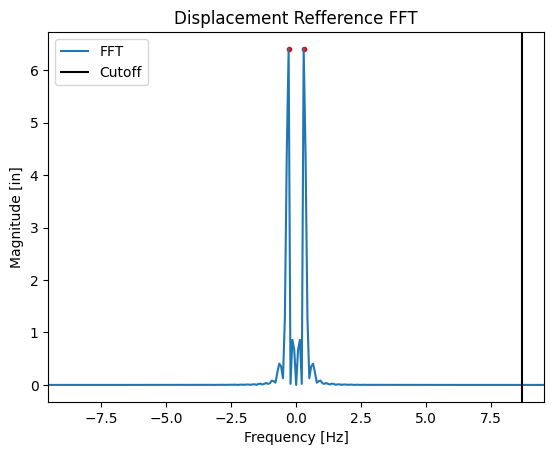

In [9]:
# FFT plots for displacement reference signal
disp_FFT    = abs(np.fft.fftshift(fft(disp_ref)))/len(disp_ref)*2;     # centered fft displacement feedback signal
f           = np.linspace(-Fs/2,Fs/2,len(disp_FFT)+1);
f           = f[0:len(disp_FFT)];

# get peak of FFT
indices     = find_peaks(disp_FFT)[0]
max_peak    = max(max(np.where(disp_FFT==np.max(disp_FFT[indices]))))

#to avoid returning 0 for the cutoff frequency
while abs(f[max_peak]) < 0.0005:                               
    indices = np.delete(indices,np.where(indices==max_peak))
    max_peak= max(max(np.where(disp_FFT==np.max(disp_FFT[indices]))))
    
f_peak      = np.abs(f[max_peak])
disp_peak   = disp_FFT[max_peak]
fc          = f_peak*fc_factor     # cutoff frequency   [Hz]

plt.plot(f_peak,disp_peak,'r.')
plt.plot(-f_peak,disp_peak,'r.')
plt.plot(f,disp_FFT,label='FFT')
plt.ylabel('Magnitude [in]')
plt.xlabel('Frequency [Hz]')
plt.title('Displacement Refference FFT')
plt.xlim([-fc*1.1, fc*1.1])
plt.axvline(x=fc, ymin=0.0, ymax=disp_peak, color='k',label='Cutoff')
plt.legend()
print('Peak frequency found to be %.2fhz'%(f_peak))

# specify minimum for regular tests and triangular that have a tendency to provide low frequency for filtering
fc_min = 0.1
if 'shape' in test_data[run]:   # shape of test run (cosine, sine or triangle)
    shape = test_data[run]['shape']
    if shape == 'triangle':
        fc_min = 1  
        
if fc<fc_min:
    fc = fc_min

print('Cutoff frequency set at %.2fhz'%fc)

In [9]:
# smooth data before and after gradient with  Savitzky-Golay filter
window_length   = 65
delay           = (window_length-1)/2  #use this to create same delay for every other signal
velocity1       = savgol_filter(disp_feedback, window_length = window_length, polyorder = 2, deriv = 1, delta = dt) #[in/s]
g               = 386.4  #[in/s^2]
ax_filt_sgolay  = savgol_filter(disp_feedback, window_length = window_length, polyorder = 2, deriv = 2, delta = dt)/g #[g]
velocity2       = np.gradient(disp_feedback)/dt

#filter acceleration data
wp = 0.1/(Fs/2)    # Normalized passband edge frequency w.r.t. Nyquist rate
Rp = 0.4          # The maximum loss in the passband (dB)
Rs = 50           # The minimum attenuation in the stopband (dB).


# Use firwin with a Kaiser window to create a lowpass FIR filter.
b           = signal.firwin(numtaps=200, cutoff=wp, window='hamming', pass_zero="lowpass")

# filtfilt is a two pass filter with no delay
ax_filt    = signal.filtfilt(b,1, acc)  # acceleration feedback low pass filtered signal
ax_filt2   = signal.filtfilt(b,1, ax_filt_sgolay) # derived acceleration with low pass
force_filt = signal.filtfilt(b,1, force)

In [11]:
#generated signal
gen = False
if 'shape' in test_data[run]:   # shape of test run (cosine, sine or triangle)
    shape = test_data[run]['shape']
    gen = True
    if shape == 'sine':
        phase    = m.pi/2+3.4*m.pi/8 #iterate to find correct phase
        w        = Vel/Amp         #angular frequency
        disp_gen = Amp*np.sin(w*time+phase)
        vel_gen  = Amp*w*np.cos(w*time+phase)
        acc_gen  = -Amp*w**2/g*np.sin(w*time+phase)
    elif shape == 'coseine':
        phase    = m.pi/2+3*m.pi/8 #iterate to find correct phase
        w        = Vel/Amp         #angular frequency
        disp_gen = Amp*np.sin(w*time+phase)
        vel_gen  = Amp*w*np.cos(w*time+phase)
        acc_gen  = -Amp*w**2/g*np.sin(w*time+phase)
    elif shape == 'triangle':
        disp_gen = Amp*np.ones(disp_feedback.shape)
        vel_gen  = Vel*np.ones(disp_feedback.shape)
        acc_gen  = 0*np.ones(disp_feedback.shape)
        print('Triangular Test')
    else:
        disp_gen = np.zeros(disp_feedback.shape)
        vel_gen  = np.zeros(disp_feedback.shape)
        acc_gen  = np.zeros(disp_feedback.shape)

## 5.  Signal Visualization <a class="anchor" id="fifth-bullet">
User can decide which signals they would like to visualize to compare filtering options based on the above descriptions. The filters selected for the machine learning notebook are: no filter for displacement and force signals as they were found to produce clean signals in most outputs, and an sgolay derivation of displacement as well as a lowpass filter was found to produce the best results for velocity and acceleration. 

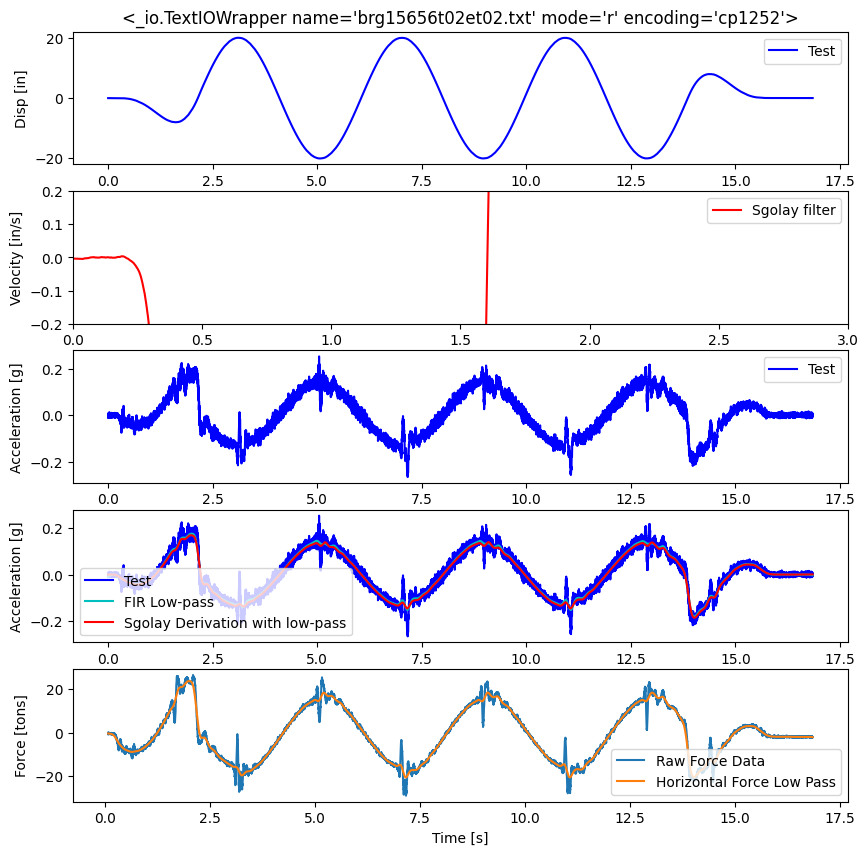

In [14]:
f, ax=plt.subplots(nrows=5,ncols=1, figsize=(10,10))
gen = False

test_color    = 'b'
filter_color  = 'c'
sgolay_color  = 'r'
generated_color = 'y--'

xlimits = [5,10]
ax1 = ax[0]
ax1.plot(time,disp_feedback,test_color,label = 'Test')
if gen:
    ax1.plot(time,disp_gen,generated_color,label = 'Generated')
#ax1.plot(time,disp_filt,filter_color,label = 'Test with delay')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Disp [in]')
ax1.set_title(file)
ax1.legend()
#ax1.set_xlim(xlimits)
#ax1.set_ylim([-36.5, -35.8])

ax2 = ax[1]
ax2.plot(time,velocity1,sgolay_color,label = 'Sgolay filter')
if gen:
    ax2.plot(time,vel_gen,generated_color,label = 'Generated')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Velocity [in/s]')
ax2.legend()
ax2.set_xlim([0,3])
ax2.set_ylim([-0.2, 0.2])

ax3 = ax[2]
ax3.plot(time,acc,test_color,label = 'Test')
if gen:
    ax3.plot(time,acc_gen,generated_color,label = 'Generated')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Acceleration [g]')
ax3.legend()
#ax3.set_xlim(xlimits)

ax3 = ax[3]
#ax3.plot(time,ax_filt_sgolay,label = 'Sgolay Derivation')
ax3.plot(time,acc,test_color,label = 'Test')
if gen:
    ax3.plot(time,acc_gen,generated_color,label = 'Generated')
ax3.plot(time,ax_filt,filter_color,label = 'FIR Low-pass')
ax3.plot(time,ax_filt2,sgolay_color,label = 'Sgolay Derivation with low-pass')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Acceleration [g]')
ax3.legend()
#ax3.set_ylim([-0.2, 0.2])
#ax3.set_xlim(xlimits)

ax3 = ax[4]
ax3.plot(time[65:],force[65:],label = 'Raw Force Data')
ax3.plot(time[65:],force_filt[65:],label = 'Horizontal Force Low Pass')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Force [tons]')
ax3.legend()